In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import arviz as az
import seaborn as sns

from REStats.utils import load_SCADA, transform, inv_transform, downsample
from REStats.circular_metrics import circular_rmse, circular_mae
from REStats.models import fit_weibull, persistence_wind_speed, backtest, persistence_wind_dir, persistence_turbulence_intensity
from REStats.plots import save_figs
from REStats.models.weibull import plot_prior_samples

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [2]:
sns.set_theme()

In [3]:
wt = load_SCADA(2019)

In [4]:
SAVE_FIGS = True
figs = {}

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data before passing it to the model.

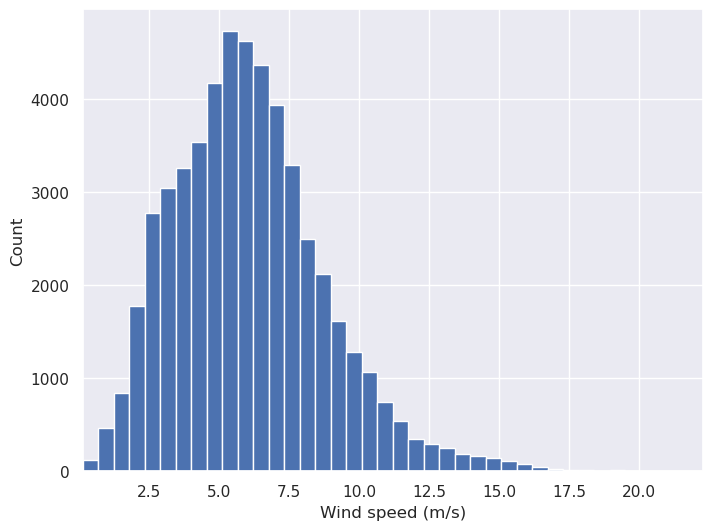

In [5]:
full_ws_hist, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Count")

b = ax.hist(wt.wind_speed, bins=40)

figs["full_ws_hist"] = full_ws_hist

In [6]:
wt_1m = wt[(wt.index >= "2019-02-01") & (wt.index < "2019-03-01")]

wt_ds = downsample(wt_1m) 

ws = wt_ds[["wind_speed"]]

/home/cam/workspace/projects/REStats/REStats/utils.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["turbulence_intensity"] = df["wind_speed"].rolling(window=6).std() / df["wind_speed"].rolling(window=6).mean()


In [7]:
wt_ds.isnull().sum()

wind_speed              0
wind_dir                0
power                   0
turbulence_intensity    0
dtype: int64

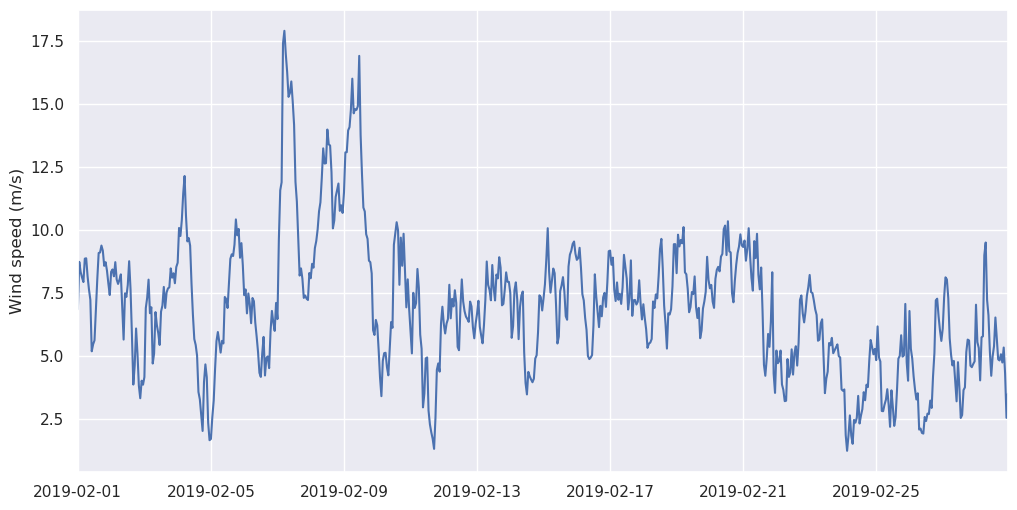

In [8]:
training_raw, ax = plt.subplots(figsize=(12, 6))

ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(wt_ds.index, wt_ds.wind_speed)

figs["training_raw"] = training_raw

## Processing: Weibull fit

In order to transform the wind speed distribution to be more Normal, fit the current distribution as Weibull using Bayesian Inference. The resulting shape parameter, $\alpha$, will be used to perform the transformation.

In [9]:
idata_wb = fit_weibull(wt_ds.wind_speed)

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:12, 119.09it/s, step size=8.21e-01, acc. prob=
Sample [1]: 100%|█| 1500/1500 [00:13, 112.17it/s, step size=8.12e-01, acc. prob=


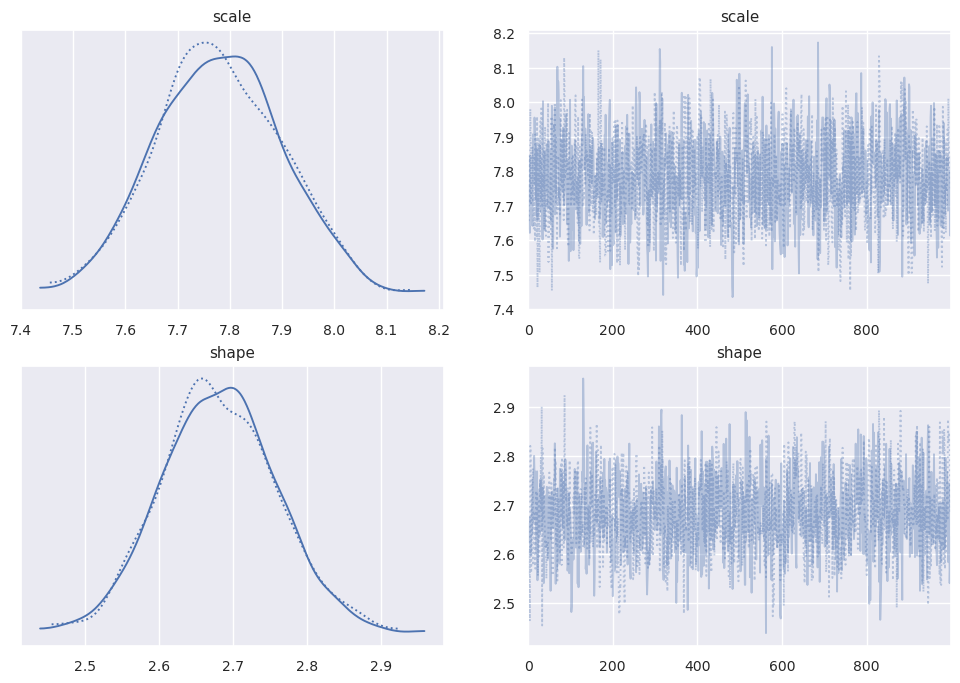

In [10]:
az.plot_trace(idata_wb, figsize=(12, 8))

wb_trace = plt.gcf()
figs["wb_trace"] = wb_trace

In [11]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 672 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1615.43    21.27
p_loo        2.83        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      672  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [12]:
idata_wb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

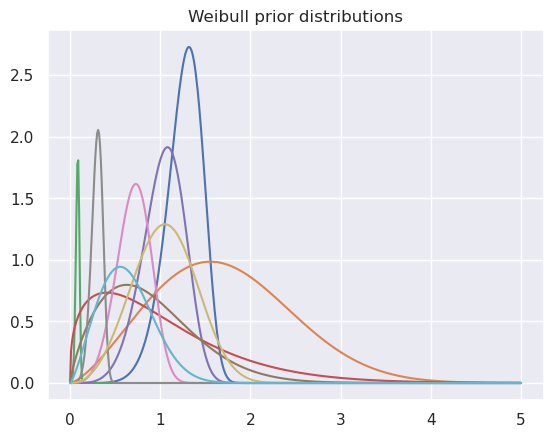

In [13]:
fig = plot_prior_samples(idata_wb)
    
figs["wb_prior"] = fig

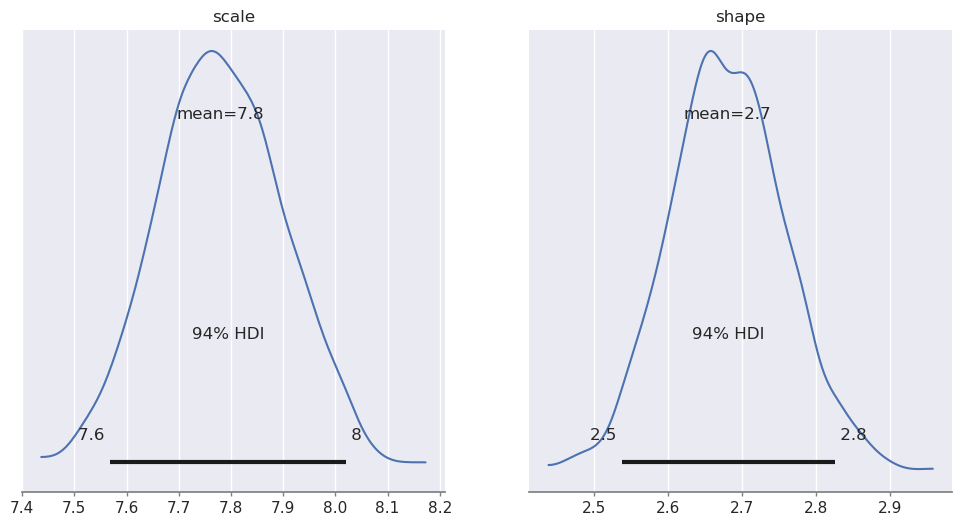

In [14]:
az.plot_posterior(idata_wb, figsize=(12, 6))

wb_posterior = plt.gcf()

figs["wb_posterior"] = wb_posterior

In [15]:
# wb_ppc, ax = plt.subplots(figsize=(8, 6))

# az.plot_ppc(idata_wb, ax=ax)
# ax.set_xlabel("Wind speed (m/s)")

# figs["wb_ppc"] = wb_ppc

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [16]:
shape = idata_wb.posterior.shape.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.scale.mean(["chain", "draw"]).item(0)

m = shape / 3.6

print(f"m: {m}")

m: 0.7446420512073862


## Modeling

Autoregressive Moving Average (ARMA) models combine autoregression (AR) and moving average (MA) terms in order to best fit the time series. The ARMA(2, 2) model has been shown in the literature to be highly competitive for short-term wind speed forecasting, though other combinations of p (AR lags) and q (MA lags) may prove better depending on the situation.

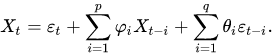

The data transformation includes both the scaling based on Weibull fit, as well as standardization based on mean/std wind speeds for given hours of the day, which helps remove diurnal nonstationarity.

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


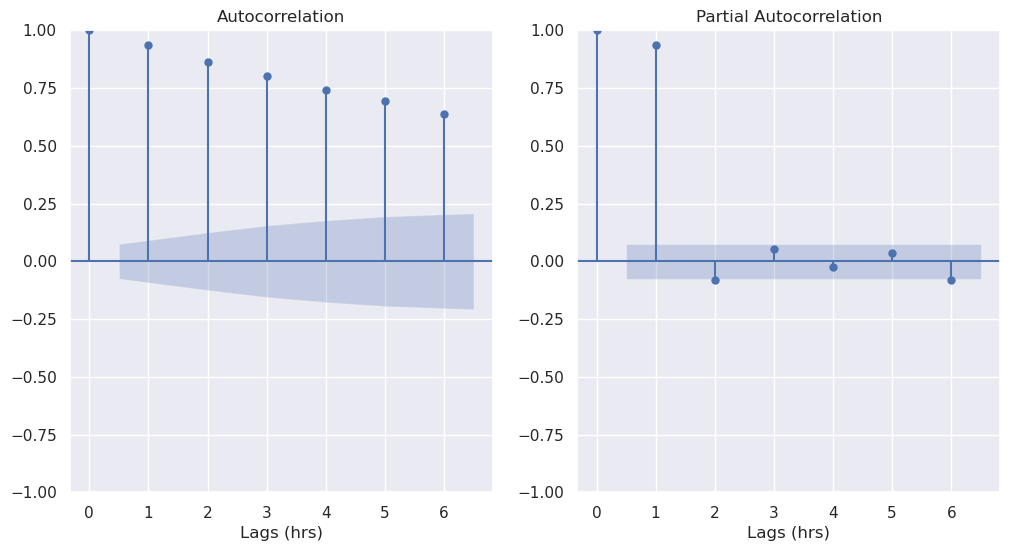

In [17]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.wind_speed, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.wind_speed, lags=6, ax=axes[1])

figs["acf_ws"] = autocorrelation

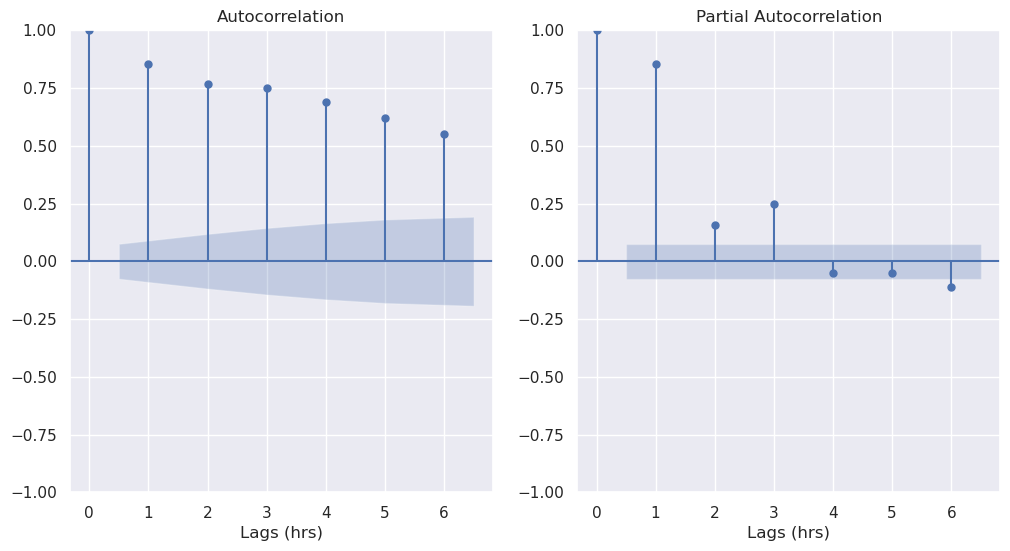

In [18]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.wind_dir, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.wind_dir, lags=6, ax=axes[1])

figs["acf_wind_dir"] = autocorrelation

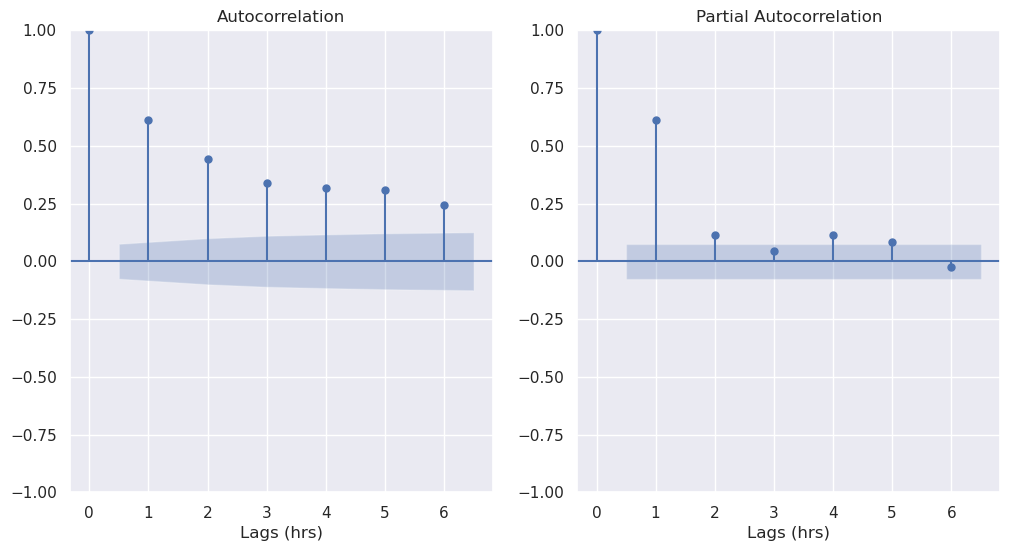

In [19]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.turbulence_intensity, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.turbulence_intensity, lags=6, ax=axes[1])

figs["acf_turbulence_intensity"] = autocorrelation

In [20]:
# Forecast wind_dir and turbulence_intensity using the persistence method
steps_ahead = 1
wind_dir_forecast = persistence_wind_dir(wt_ds, steps_ahead)
turbulence_intensity_forecast = persistence_turbulence_intensity(wt_ds, steps_ahead)

# Calculate RMSE and MAE for the wind_dir persistence method predictions
wind_dir_rmse = circular_rmse(wt_ds["wind_dir"][steps_ahead:], wind_dir_forecast.dropna())
wind_dir_mae = circular_mae(wt_ds["wind_dir"][steps_ahead:], wind_dir_forecast.dropna())

# Calculate RMSE and MAE for the turbulence_intensity persistence method predictions
turbulence_intensity_rmse = mean_squared_error(wt_ds["turbulence_intensity"][steps_ahead:], turbulence_intensity_forecast.dropna(), squared=False)
turbulence_intensity_mae = mean_absolute_error(wt_ds["turbulence_intensity"][steps_ahead:], turbulence_intensity_forecast.dropna())

# Print the RMSE and MAE values
print("Wind direction RMSE:", wind_dir_rmse)
print("Wind direction MAE:", wind_dir_mae)
print("Turbulence intensity RMSE:", turbulence_intensity_rmse)
print("Turbulence intensity MAE:", turbulence_intensity_mae)


Wind direction RMSE: 12.979217756324138
Wind direction MAE: 8.061766490596876
Turbulence intensity RMSE: 0.04708756085373081
Turbulence intensity MAE: 0.03265952483134204


In [21]:
ws_tf, hr_stats = transform(ws, m)

ws_tf.head()

,wind_speed,v_scaled,v,hr,v_scaled_std
Date,,,,,
2019-02-01 00:00:00,6.851252,4.191307,6.851252,0,-0.017900
2019-02-01 01:00:00,8.726291,5.018586,8.726291,1,0.667049
2019-02-01 02:00:00,8.323363,4.844993,8.323363,2,0.474690
2019-02-01 03:00:00,8.106309,4.750594,8.106309,3,0.336506
2019-02-01 04:00:00,7.925400,4.671421,7.925400,4,0.198503


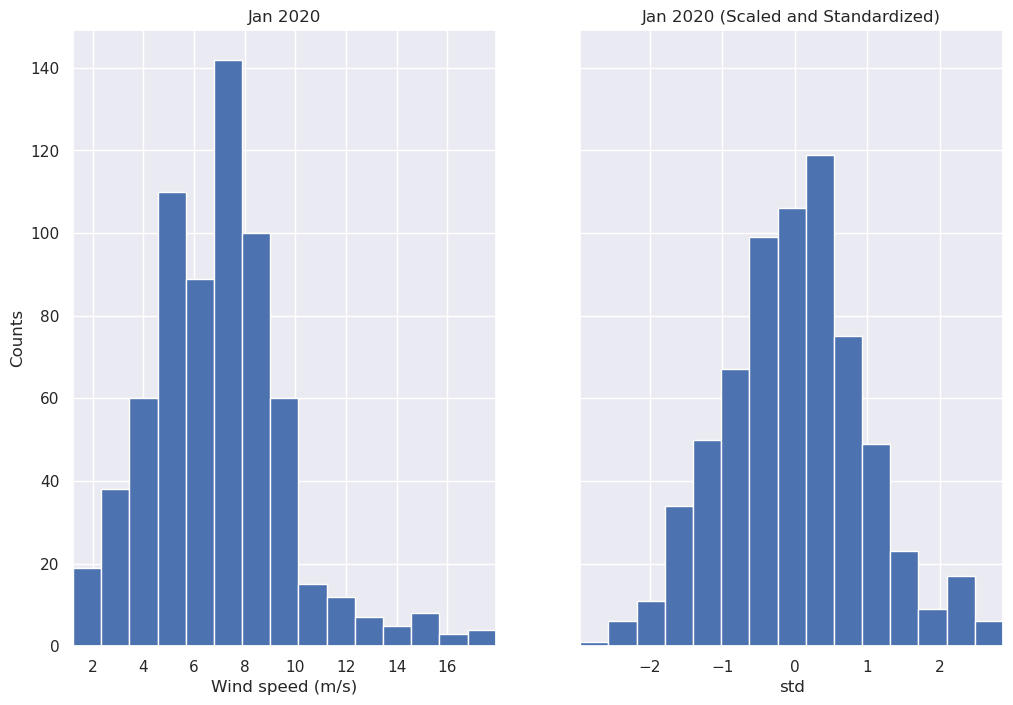

In [22]:
ws_hist_std_comparison, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

[ax.set_xmargin(0) for ax in axes]
axes[0].set_ylabel("Counts")
axes[0].hist(ws_tf.v, bins=15)
axes[0].set_title("Jan 2020")
axes[0].set_xlabel("Wind speed (m/s)")
axes[1].hist(ws_tf.v_scaled_std, bins=15)
axes[1].set_title("Jan 2020 (Scaled and Standardized)")
axes[1].set_xlabel("std")

figs["ws_hist_std_comparison"] = ws_hist_std_comparison

In [23]:
arma_mod = ARIMA(ws_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  672
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -272.553
Date:                Mon, 10 Apr 2023   AIC                            555.106
Time:                        16:05:34   BIC                            577.657
Sample:                    02-01-2019   HQIC                           563.840
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4973      0.270      1.841      0.066      -0.032       1.027
ar.L2          0.4091      0.245      1.670      0.095      -0.071       0.889
ma.L1          0.4620      0.271      1.708      0.0

In [24]:
pred = arma_res.get_prediction().summary_frame()
pred = pred.copy()
pred

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2019-02-01 00:00:00,0.000000,0.982910,-1.926469,1.926469
2019-02-01 01:00:00,-0.016622,0.364658,-0.731339,0.698094
2019-02-01 02:00:00,0.634867,0.364551,-0.079640,1.349375
2019-02-01 03:00:00,0.376785,0.363026,-0.334734,1.088304
2019-02-01 04:00:00,0.356885,0.362673,-0.353940,1.067711
...,...,...,...,...
2019-02-28 19:00:00,-0.615815,0.362445,-1.326194,0.094563
2019-02-28 20:00:00,-1.103994,0.362445,-1.814373,-0.393616
2019-02-28 21:00:00,-0.804104,0.362445,-1.514483,-0.093726


Reverse the transformations for error calculations and plotting.

In [25]:
inv_pred = inv_transform(pred, m, hr_stats)
rmse = mean_squared_error(ws_tf.v, inv_pred["mean"], squared=False)
print("RMSE:", rmse)

RMSE: 0.9223778669843133


In [26]:
per = ws_tf.v.shift(1).bfill()
per_rmse = mean_squared_error(ws_tf.v, per, squared=False)
per_rmse

0.9755607840147397

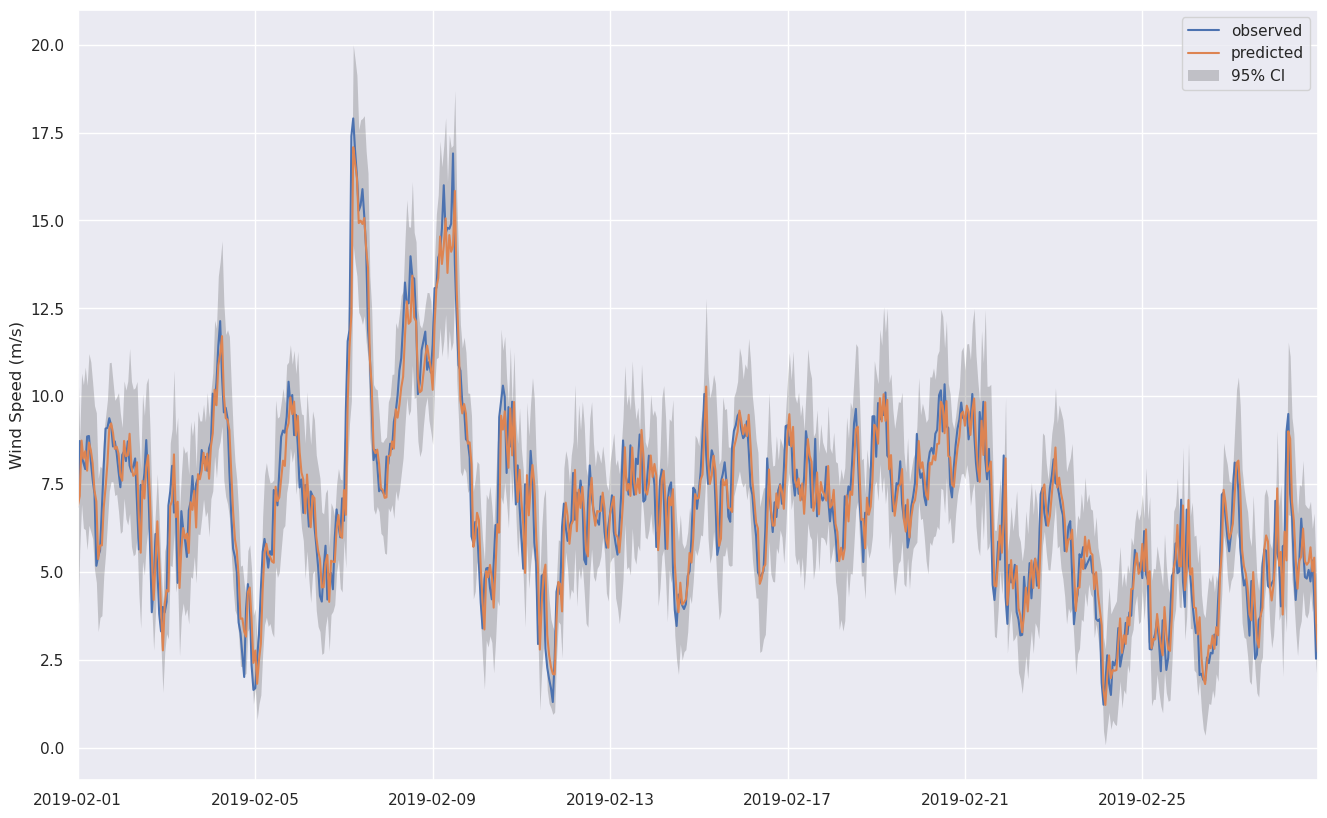

In [27]:
arma_fit_results, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(ws_tf.index, ws_tf.v, label="observed")

ax.plot(inv_pred.index, inv_pred["mean"], label="predicted")
ax.fill_between(
    inv_pred.index, 
    inv_pred.mean_ci_lower, 
    inv_pred.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()

figs["arma_fit_results"] = arma_fit_results

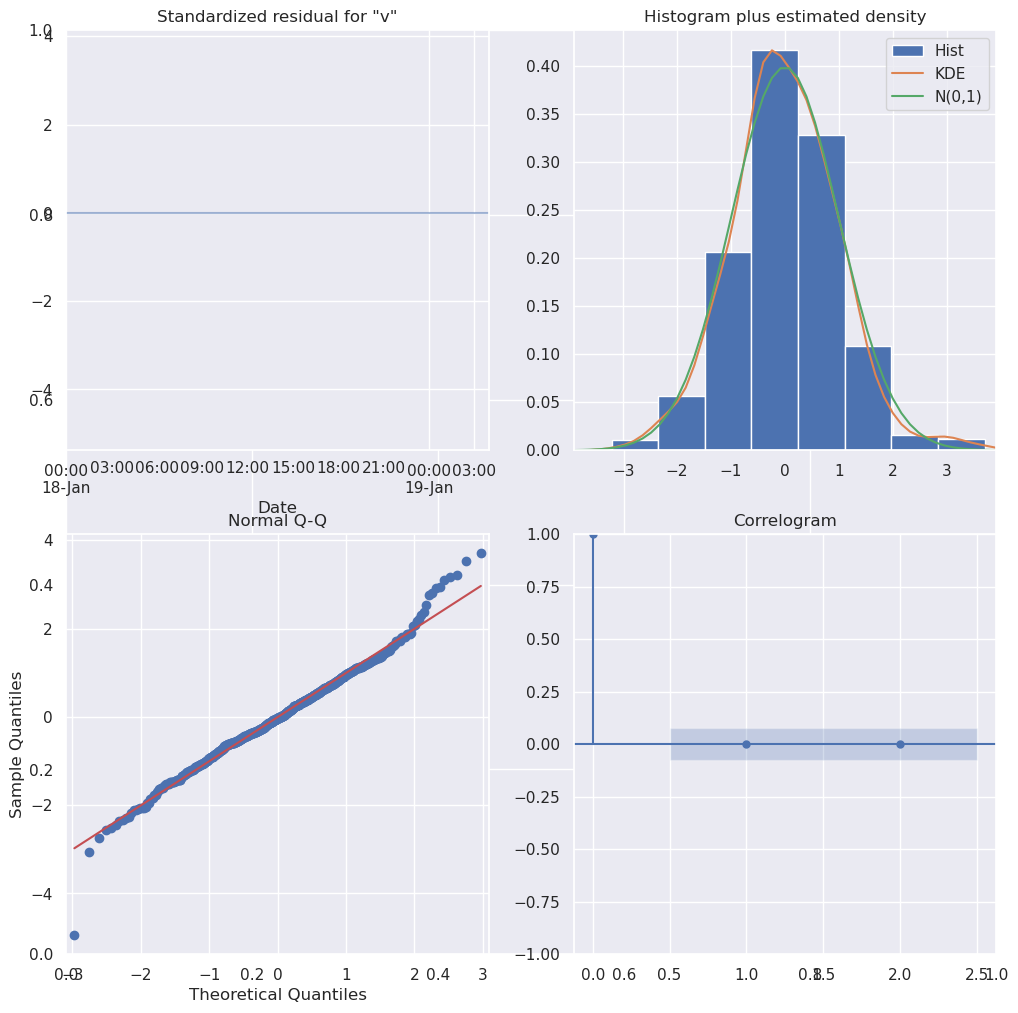

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

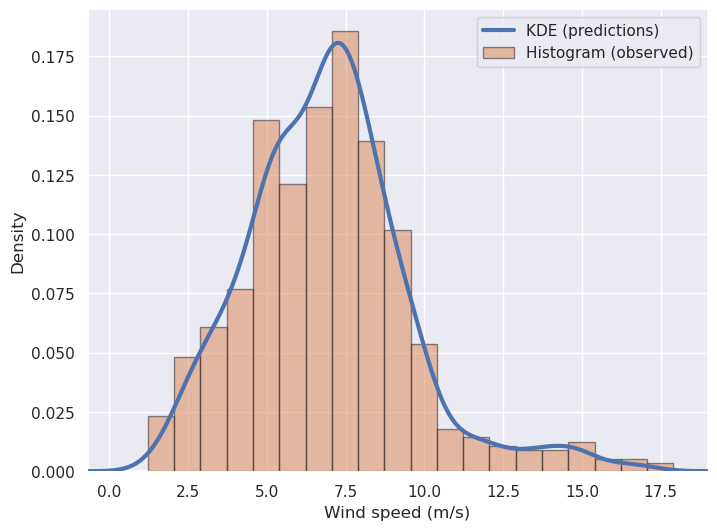

In [29]:
kde = sm.nonparametric.KDEUnivariate(inv_pred["mean"])
kde.fit()  # Estimate the densities

arma_fit_kde, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    ws_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

figs["arma_fit_kde"] = arma_fit_kde

## Forecast

In [30]:
wt_t = wt[(wt.index >= "2020-03-01") & (wt.index < "2020-04-01")].copy()
wt_t.isnull().sum()

power         0.0
wind_dir      0.0
wind_speed    0.0
dtype: float64

In [31]:
wt_train = wt[(wt.index >= "2019-02-01") & (wt.index < "2019-03-01")].copy()
wt_test = wt[(wt.index >= "2019-03-01") & (wt.index < "2019-04-01")].copy()

v_train = wt_train[["wind_speed"]].resample("H").mean()
assert v_train["wind_speed"].isnull().sum() == 0 # sanity check
v_test = wt_test[["wind_speed"]].resample("H").mean()
assert v_test["wind_speed"].isnull().sum() == 0 # sanity check

In [32]:
forecasts_full, (fcast_rmse, fcast_mae) = backtest(v_train, v_test)

forecasts_full.head()

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:12, 121.47it/s, step size=8.29e-01, acc. prob=
Sample [1]: 100%|█| 1500/1500 [00:12, 116.24it/s, step size=6.73e-01, acc. prob=


Forecast RMSE: 1.1149798548379584
Forecast MAE: 0.8302882176393277


v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-03-01 01:00:00,3.154044,8.017925,1.939547,4.504090
2019-03-01 02:00:00,4.036259,8.034973,2.592120,5.628543
2019-03-01 03:00:00,2.487279,8.180458,1.114660,4.096997
2019-03-01 04:00:00,4.726105,8.455336,2.846254,6.823815
2019-03-01 05:00:00,6.421425,8.533141,4.304536,8.736243


In [33]:
persistence_wind_speed(v_test["wind_speed"])

PER RMSE: 1.0665964958934706
PER MAE: 0.787914913415891


(1.0665964958934706, 0.787914913415891)

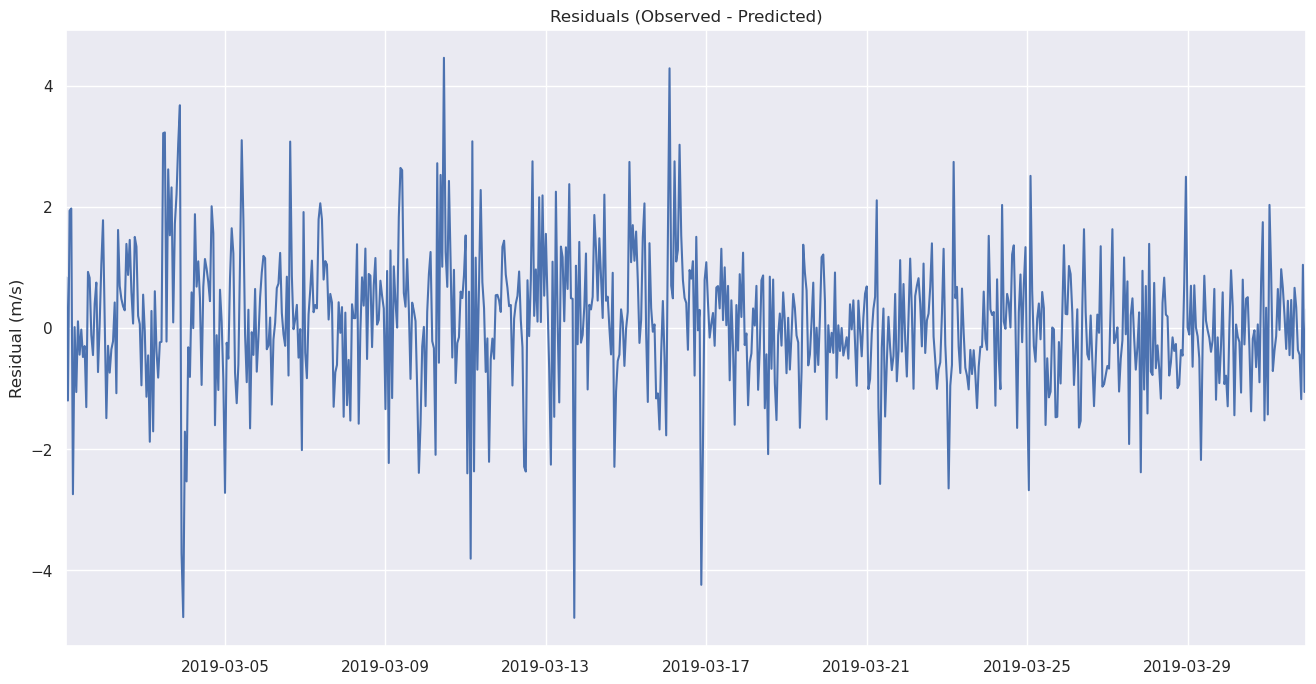

In [34]:
arma_forecast_resid, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Residual (m/s)")
ax.set_xmargin(0)
ax.set_title("Residuals (Observed - Predicted)")

resid = v_test["wind_speed"][1:] - forecasts_full["mean"]

ax.plot(forecasts_full.index, resid)

figs["arma_forecast_resid"] = arma_forecast_resid

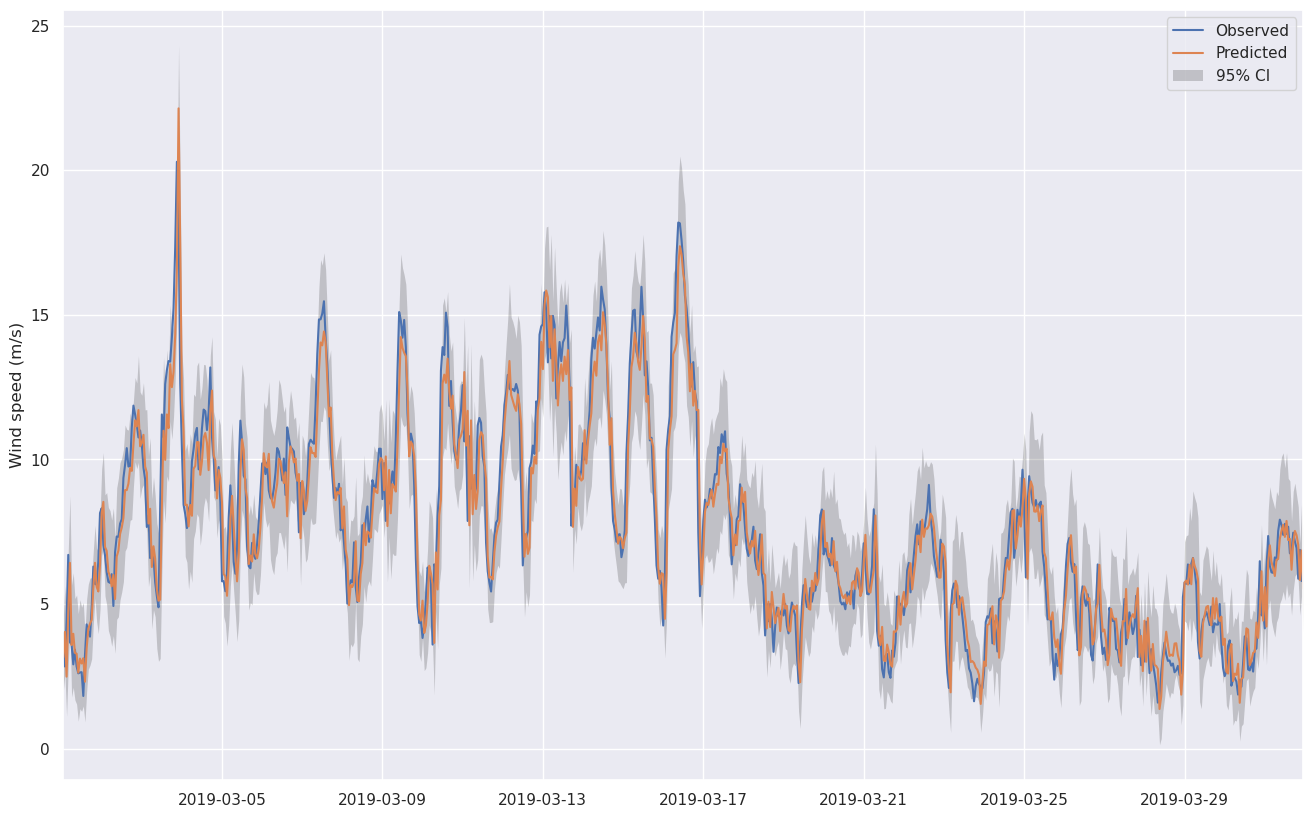

In [35]:
arma_forecast_results, ax = plt.subplots(figsize=(16, 10))
ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(v_test.index[1:], v_test[1:], label="Observed")
ax.plot(forecasts_full.index, forecasts_full["mean"], label="Predicted")


ax.fill_between(
    forecasts_full.index, 
    forecasts_full.mean_ci_lower, 
    forecasts_full.mean_ci_upper,
    color="k", alpha=.2, linewidth=0, label="95% CI"
)

ax.legend()

figs["arma_forecast_results"] = arma_forecast_results

In [36]:
if SAVE_FIGS:
    save_figs(figs)